In [0]:
## install

# !pip install gym[atari]

In [0]:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
## setup

import gym

import numpy as np
from matplotlib import pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
import time
import pickle
from google.colab import files

# neural network
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import tensorflow as tf

# video
import imageio
# embed video to notebook
import base64
# interactive architecture for jupyter notebook
import IPython

In [0]:
## hyperparameter

MAX_LENGTH_REPLAY = 10000
VIDEO_NAME_RANDOM = 'random_agent.mp4'
HEIGHT = 210
WIDTH = 160
CHANNEL = 3
N_OUT = 6
LEARNING_RATE = 0.001 # learning rate in neural network optimizer
GAMMA = 0.99 # discount factor
EPSILON = 1.0
EPSILON_MIN = 0.1
# EPSILON_DECAY = 0.99
EPSILON_DECAY = 0.999
EPSILON_EVAL = 0.01 # epsilon-greedy method in evaluation environment
BATCH_SIZE = 32
TIME_STEP = 200
MODEL_PATH = 'model.h5'
FIGURE_PATH = 'dqn_reward.png'
REWARD_PATH = 'rewards.sav'
VIDEO_PATH = 'dqn_v1.mp4'

EPISODES = 1000
MONITOR_INTERVAL = 100
EVAL_STEP = 400
EVAL_EPISODES = 1

action space Discrete(6)
meaning of action space ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
observation space Box(210, 160, 3)


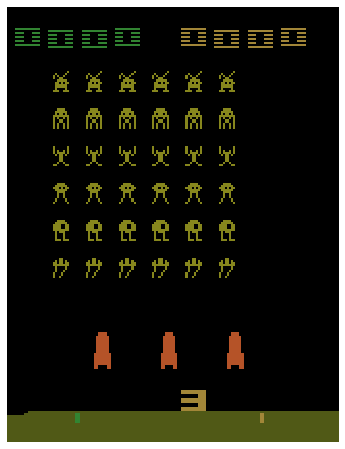

In [67]:
## environment

env = gym.make('SpaceInvaders-v0')
env.reset()

# show spec
# Discrete(6) but action index includes 0, 1, 2, 3, 4, 5
print("action space", env.action_space)
print("meaning of action space", env.get_action_meanings())
print("observation space", env.observation_space)

# show environment
plt.figure(figsize = (8, 8))
plt.imshow(env.render('rgb_array'))
plt.axis('off')
plt.show()

In [0]:
## experience replay

class Replay:
    def __init__(self):
        self.buffer = []
        self.length = 0
        self.max_length = MAX_LENGTH_REPLAY

    def write(self, data):
        # if replay is full, delete the oldest (first list) and append the new
        if self.length >= self.max_length:
            self.buffer.pop(0)
            self.length -= 1
        self.buffer.append(data)
        self.length += 1

    def read(self, batch_size):
        # at beginning buffer is almost empty, so batch is smaller than batch_size
        # random.sample is k sample from population without replacement
        return random.sample(population = self.buffer, k = min(batch_size, self.length))

In [0]:
## network

class Network:
    def __init__(self, height, width, channel, n_out):
        self.height = height
        self.width = width
        self.channel = channel
        self.n_out = n_out

    def _build_model_1(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (self.height, self.width, self.channel,)))
        model.add(Conv2D(32, (3, 3), activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Flatten())
        model.add(Dense(32, activation = 'relu'))
        model.add(Dense(self.n_out, activation = 'linear'))
        optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)
        model.compile(loss = 'mse', optimizer = optimizer)
        return model

    def _build_model_2(self):
        model = Sequential()
        model.add(Conv2D(16, (4, 4), padding = 'same', activation = 'relu', 
                         input_shape = (self.height, self.width, self.channel,),
                         strides = 3))
        model.add(MaxPooling2D(pool_size = (4, 4)))
        model.add(Flatten())
        model.add(Dense(16, activation = 'relu'))
        model.add(Dense(self.n_out, activation = 'linear'))
        optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
        model.compile(loss = 'mse', optimizer = optimizer)
        return model

In [0]:
## agent

class Agent:
    def __init__(self):
        self.height = HEIGHT
        self.width = WIDTH
        self.channel = CHANNEL
        self.n_out = N_OUT
        self.total_reward = 0
        self.gamma = GAMMA # discount factor
        self.epsilon = EPSILON
        self.epsilon_min = EPSILON_MIN
        self.epsilon_decay = EPSILON_DECAY
        self.batch_size = BATCH_SIZE
        self.replay_buffer = Replay()
        # self.model = Network(self.height, self.width, self.channel, self.n_out)._build_model_1()
        self.model = Network(self.height, self.width, self.channel, self.n_out)._build_model_2()

    def gather_experience(self, last_state, action, reward, state):
        self.replay_buffer.write((last_state, action, reward, state))

    def set_total_reward(self, new_total):
        self.total_reward = new_total

    def gather_reward(self, reward):
        self.total_reward += reward

    def get_total_reward(self):
        return self.total_reward

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def reshape_state(self, state):
        return np.reshape(state, (-1, self.height, self.width, self.channel))

    def choose_action(self, state):
        if np.random.rand() > self.epsilon:
            state = self.reshape_state(state)
            return np.argmax(self.model.predict(state)[0])
        else:
            return np.random.randint(low = 0, high = self.n_out - 1, size = None, dtype = 'int')

    def update_q(self):

        # checkpoint
        # now = time.time()
        
        batch = self.replay_buffer.read(self.batch_size)

        # checkpoint
        # prev = now; now = time.time(); print("sampled batch", round(now - prev, 2))

        n = len(batch)

        # extract batch
        last_states = np.array([b[0] for b in batch])
        actions = np.array([b[1] for b in batch])
        rewards = np.array([b[2] for b in batch])
        states = np.array([b[3] for b in batch])
        done_index = [np.any(s) == False for s in states]

        # checkpoint
        # prev = now; now = time.time(); print("extracted batch", round(now - prev, 2))

        # predictions
        q_lasts = self.model.predict(last_states)
        q_these = self.model.predict(states)
        ys = rewards + self.gamma * np.amax(q_these, axis = 1)
        index = np.arange(0, len(q_lasts))
        q_lasts[index, actions] = ys

        if sum(done_index) > 0:
            q_lasts[done_index, actions[done_index]] = rewards[done_index][0]

        # checkpoint
        # prev = now; now = time.time(); print("updated q", round(now - prev, 2))

        history = self.model.fit(last_states, q_lasts, epochs = 1, verbose = 0)

        # checkpoint
        # prev = now; now = time.time(); print("updated model", round(now - prev, 2))

        return history.history['loss'][0]

episode:0, reward:35.0, epsilon:0.999, time:6.0
episode:100, reward:15.0, epsilon:0.90389, time:486.0
episode:200, reward:5.0, epsilon:0.81783, time:952.0
episode:300, reward:20.0, epsilon:0.73997, time:1420.0
episode:400, reward:60.0, epsilon:0.66952, time:1897.0
episode:500, reward:45.0, epsilon:0.60577, time:2377.0
episode:600, reward:30.0, epsilon:0.5481, time:2838.0
episode:700, reward:35.0, epsilon:0.49592, time:3300.0
episode:800, reward:55.0, epsilon:0.4487, time:3763.0
episode:900, reward:15.0, epsilon:0.40598, time:4228.0


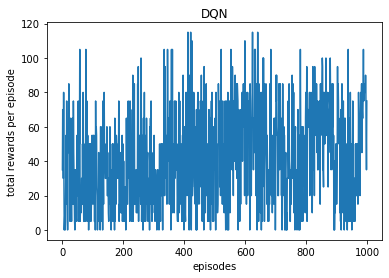

In [71]:
## training

# If update_q spends 0.05 seconds and time step is 200, 1 episode can finish with 10 seconds. Now update_q spends 0.2 seconds

start_time = time.time()
# now = time.time()

agent = Agent()
ep_rewards = []
loss = False
losses = []

for ep in range(EPISODES):
    last_state = env.reset()
    agent.set_total_reward(0)

    for t in range(TIME_STEP):

        # checkpoint
        # prev = now; now = time.time(); print("before choose action", round(now - prev, 2))

        action = agent.choose_action(last_state)

        # checkpoint
        # prev = now; now = time.time(); print("choose action", round(now - prev, 2))

        state, reward, done, info = env.step(action)

        if done == True:
            state = np.zeros((1, 210, 160, 3))

        agent.gather_reward(reward)
        
        agent.gather_experience(last_state, action, reward, state)

        # checkpoint
        # prev = now; now = time.time(); print("gather experience", round(now - prev, 2))

        loss = agent.update_q()

        # checkpoint
        # prev = now; now = time.time(); print("updated q", round(now - prev, 2))

        last_state = state

        if done == True:
            ep_rewards.append(agent.get_total_reward())
            break

    if done == False:
        ep_rewards.append(agent.get_total_reward())

    if loss:
        losses.append(loss)

    agent.decay_epsilon()

    # monitoring
    if ep % MONITOR_INTERVAL == 0:
        print("episode:{}, reward:{}, epsilon:{}, time:{}".format(ep, 
                                                                  agent.get_total_reward(),
                                                                  np.round(agent.epsilon, decimals = 5),
                                                                  np.round(time.time() - start_time, decimals = 0)))
        
agent.model.save(MODEL_PATH)

episode = range(0, EPISODES, 1)
plt.plot(episode, ep_rewards)
plt.ylabel("total rewards per episode")
plt.xlabel("episodes")
plt.title("DQN")
plt.savefig(FIGURE_PATH)
plt.show()
pickle.dump(ep_rewards, open(REWARD_PATH, 'wb'))

In [72]:
## evaluation video

"""
this code outputs mp4 file. 
If you run this in your local PC, video file will be saved in your local directory.
If it's Colab, the video file 
"""

eval_model = load_model(MODEL_PATH)

# what's this?
fps = 30

with imageio.get_writer(VIDEO_PATH, fps = fps) as video:
    for _ in range(EVAL_EPISODES):
        # initialize
        state = env.reset()
        done = False
        video.append_data(env.render('rgb_array'))
        
        # start episode
        while not done:
            if np.random.rand() > EPSILON_EVAL:
                state = np.reshape(state, (-1, HEIGHT, WIDTH, CHANNEL))
                action = np.argmax(eval_model.predict(state)[0])
            else:
                action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')

            # get next state
            next_state, reward, done, info = env.step(action)
            video.append_data(env.render('rgb_array'))

            # iteration
            state = next_state

In [76]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'dqn_v1.mp4'})
uploaded.SetContentFile('dqn_v1.mp4')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

Uploaded file with ID 1CsyInKwUTVn-Pb1Lycx47S6bIDHD8v8k


In [77]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'model.h5'})
uploaded.SetContentFile('model.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1F0DqLOOIEcWkntO2RSHs4FoFB55wGa3b


In [0]:
# ## evaluation picture story show

# eval_model = load_model(MODEL_PATH)

# state = env.reset()

# for i in range(EVAL_STEP):
#     clear_output(wait = True)

#     if np.random.rand() > EPSILON_EVAL:
#         state = np.reshape(state, (-1, HEIGHT, WIDTH, CHANNEL))
#         action = np.argmax(eval_model.predict(state)[0])
#     else:
#         action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')

#     next_state, reward, done, info = env.step(action)
    
#     plt.figure(figsize = (6, 6))
#     plt.imshow(next_state)
#     plt.axis('off')

#     print("step:{}, action:{}, reward:{}, done:{}".format(i, action, reward, done))
#     plt.show()
#     sleep(.5)

In [0]:
# ## Improve time by modifying experience replay

# ## agent 2

# class Agent:
#     def __init__(self):
#         self.height = HEIGHT
#         self.width = WIDTH
#         self.channel = CHANNEL
#         self.n_out = N_OUT
#         self.total_reward = 0
#         self.gamma = GAMMA # discount factor
#         self.epsilon = EPSILON
#         self.epsilon_min = EPSILON_MIN
#         self.epsilon_decay = EPSILON_DECAY
#         self.batch_size = BATCH_SIZE
#         self.replay_buffer = Replay()
#         self.model = Network(self.height, self.width, self.channel, self.n_out)._build_model()

#     # def gather_experience(self, last_state, action, reward, state):
#         # self.replay_buffer.write((last_state, action, reward, state))

#     # under developing
#     def gather_experience(self, last_state, action, reward, state):
#         data = np.array([[last_state, action, reward, state]])
#         self.replay_buffer.write(data)

#     def set_total_reward(self, new_total):
#         self.total_reward = new_total

#     def gather_reward(self, reward):
#         self.total_reward += reward

#     def get_total_reward(self):
#         return self.total_reward

#     def decay_epsilon(self):
#         if self.epsilon > self.epsilon_min:
#             self.epsilon *= self.epsilon_decay

#     def reshape_state(self, state):
#         return np.reshape(state, (-1, self.height, self.width, self.channel))

#     def choose_action(self, state):
#         if np.random.rand() > self.epsilon:
#             state = self.reshape_state(state)
#             return np.argmax(self.model.predict(state)[0])
#         else:
#             return np.random.randint(low = 0, high = self.n_out - 1, size = None, dtype = 'int')

#     # def update_q(self):
#     def update_q(self, now):
#         batch = self.replay_buffer.read(self.batch_size)
#         n = len(batch)

#         # checkpoint
#         # prev = now; now = time.time(); print("read batch", round(now - prev, 2))

#         x_batch = np.zeros([n, self.height, self.width, self.channel])
#         y_batch = np.zeros([n, self.n_out])

#         i = 0

#         for b in batch:
#             last_state, action, reward, state = b
#             last_state = self.reshape_state(last_state)
#             q_last = self.model.predict(last_state)[0]

#             # checkpoint
#             # prev = now; now = time.time(); print("calculate q_last", round(now - prev, 2))

#             if state is None:
#                 q_last[action] = reward
#             else:
#                 state = self.reshape_state(state)
#                 q_this = self.model.predict(state)[0]
#                 y = reward + self.gamma * np.max(q_this)
#                 q_last[action] = y

#             # checkpoint
#             # prev = now; now = time.time(); print("update q_last", round(now - prev, 2))
            
#             x_batch[i, :] = last_state
#             y_batch[i, :] = q_last
#             i + 1
        
#         # checkpoint
#         prev = now; now = time.time(); print("finish q loop", round(now - prev, 2))

#         history = self.model.fit(x_batch, y_batch, epochs = 1, verbose = 0)

#         # checkpoint
#         prev = now; now = time.time(); print("train model", round(now - prev, 2))

#         return history.history['loss'][0]

In [0]:
# class Replay:
#     def __init__(self):
#         self.buffer = False
#         self.length = 0
#         self.max_length = MAX_LENGTH_REPLAY

#     def write(self, data):
#         if self.buffer == False:
#             self.buffer = data
#             self.length = 1
#         elif self.length > 0 and self.length < self.max_length:
#             self.buffer = np.append(self.buffer, data, axis = 0)
#             self.length = len(self.buffer)
#         elif self.length >= self.max_length:
#             np.delete(arr = self.buffer, obj = 0, axis = 0)
#             self.buffer = np.append(self.buffer, data, axis = 0)

#     def read(self, batch_size):
#         # at beginning buffer is almost empty, so batch is smaller than batch_size
#         index = np.random.choice(a = self.length, size = min(batch_size, self.length), replace = False)
#         return self.buffer[index, :]

In [0]:
# last_state = env.reset()
# last_state.shape

In [0]:
# ## batch to improve time

# replay_buffer = Replay()
# last_state = env.reset()

# for _ in range(5):

#     action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')
#     state, reward, done, info = env.step(action)
#     replay_buffer.write(np.array([[last_state, action, reward, state]]))
#     last_state = state

In [0]:
# replay_buffer.buffer.shape

In [0]:
# ## improve time

# batch = replay_buffer.read(BATCH_SIZE)
# n = len(batch)
# print(n)
# print(batch.shape)
# print(batch[:, 0].shape)
# print(type(batch[:, 0]))


# ## original
#         # for b in batch:
#         #     last_state, action, reward, state = b
#         #     last_state = self.reshape_state(last_state)
#         #     q_last = self.model.predict(last_state)[0]

#         #     # checkpoint
#         #     # prev = now; now = time.time(); print("calculate q_last", round(now - prev, 2))

#         #     if state is None:
#         #         q_last[action] = reward
#         #     else:
#         #         state = self.reshape_state(state)
#         #         q_this = self.model.predict(state)[0]
#         #         y = reward + self.gamma * np.max(q_this)
#         #         q_last[action] = y

#         #     # checkpoint
#         #     # prev = now; now = time.time(); print("update q_last", round(now - prev, 2))
            
#         #     x_batch[i, :] = last_state
#         #     y_batch[i, :] = q_last
#         #     i + 1

In [0]:
# ## debug replay buffer

# last_state = env.reset()
# action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')
# state, reward, done, info = env.step(action)

# buffer = np.array([[last_state, action, reward, state]])

# last_state = env.reset()
# action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')
# state, reward, done, info = env.step(action)

# data = np.array([[last_state, action, reward, state]])

# tmp = np.append(buffer, data, axis = 0)

# tmp.shape

# # print("tmp[0, :]", tmp[0, :])
# print(tmp[:, 0].shape)
# print(tmp[0, 0].shape)

In [0]:
# ## debug plot

# episode = range(0, EPISODES, 1)
# print(len(episode))
# print(len(ep_rewards))
# print(ep_rewards)

# episode = range(0, EPISODES, 1)
# plt.plot(episode, ep_rewards)
# plt.ylabel("total rewards per episode")
# plt.xlabel("episodes")
# plt.title("DQN")
# plt.savefig(FIGURE_PATH)
# plt.show()

In [0]:
# ## debug model prediction

# tmp = env.reset()
# print("input shape:", tmp.shape)

# model = Network(height = HEIGHT, width = WIDTH, channel = CHANNEL, n_out = N_OUT)._build_model()
# print(model.summary())

# tmp = np.reshape(tmp, (-1, HEIGHT, WIDTH, CHANNEL))
# print(tmp.shape)

# pred = model.predict(tmp)[0]
# print(pred)

In [0]:
# ## make mp4 video file

# """
# this code outputs mp4 file. 
# If you run this in your local PC, video file will be saved in your local directory.
# If it's Colab, the video file 
# """

# # what's this?
# fps = 30
# num_episodes = 1

# with imageio.get_writer(VIDEO_NAME_RANDOM, fps = fps) as video:
#     for _ in range(num_episodes):
#         # initialize
#         time_step = env.reset()
#         done = False
#         video.append_data(env.render('rgb_array'))
        
#         # start episode
#         while not done:
#             # draw random action
#             action = np.random.randint(low = 0, high = 5, size = None, dtype = 'int')
#             # get next state
#             next_state, reward, done, info = env.step(action)
#             video.append_data(env.render('rgb_array'))

# # files.download(VIDEO_NAME_RANDOM)  

In [0]:
# ## embed video in this notebook

# video = open(VIDEO_NAME_RANDOM, 'rb').read()
# print("Type of video:", type(video))
# print("Length of video file:", len(video))

# # encode a string using Base64, returns encoded string, used to generate URL
# b64 = base64.b64encode(video)
# # print("b64encode:", b64)

# tag = '''
#       <video width = "640" height = "480" controls>
#           <source src = "data:video/mp4; base64, {0}" type = "video/mp4">
#       Your browser does not support the video tag.
#       </video>
#       '''.format(b64.decode())

# # print("tag:", tag)

# IPython.display.HTML(tag)